In [1]:
%run ../../base-notebook.ipynb

TensorFlow version: 2.12.0
TensorFlow-Text version: 2.12.0
Python version 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]


In [2]:
import so_ml_tools as soml

import tensorflow_hub as hub

from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Get data (10 percent of food classes)
soml.util.io.download_file(source='https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip', filepath='./10_food_classes_10_percent.zip')
soml.util.io.extract_zip(filepath='10_food_classes_10_percent.zip')

Download of https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip completed.


In [4]:
soml.util.io.list_dir_summary(folder='./data/10_food_classes_10_percent')

There are 2 directories, and 0 in ./data/10_food_classes_10_percent
There are 10 directories, and 0 in ./data/10_food_classes_10_percent/test
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/ice_cream
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/chicken_curry
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/steak
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/sushi
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/chicken_wings
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/grilled_salmon
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/hamburger
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/pizza
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/ramen
There are 0 directories, and 250 in ./data/10_food_classes_10_percent/test/fried_rice
There are 

In [5]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

TRAIN_DIR = 'data/10_food_classes_10_percent/train'
TEST_DIR = 'data/10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(directory=TRAIN_DIR, target_size=IMAGE_SHAPE)

print("Test images:")
test_data = train_datagen.flow_from_directory(directory=TEST_DIR, target_size=IMAGE_SHAPE)

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


In [6]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
efficientnetB4_url = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'

In [7]:
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    :param model_url: A TensorFlow Hub feature extraction URL.
    :param num_classes: Number of output neurons in the output layer, should be equal to number of classes.
    :return: An un-compiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
    """
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # Freeze the already learned patterns.
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE+(3,))

    model = Sequential([
        feature_extractor_layer,
        Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

In [8]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

Metal device set to: Apple M1 Max


In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
resnet_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [11]:
cb_tensorboard = soml.tf.model.callback.tensorboard_callback(experiment_name='resnet_model_history')

resnet_history = resnet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])


Saving TensorBoard log files to: ./logs/resnet_model_history/20230831-222437
Epoch 1/5


2023-08-31 22:24:37.322906: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 13s 389ms/step - loss: 1.8105 - accuracy: 0.3947 - val_loss: 1.1077 - val_accuracy: 0.6580
Epoch 2/5
24/24 [==============================] - 8s 333ms/step - loss: 0.8328 - accuracy: 0.7627 - val_loss: 0.8087 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - 8s 331ms/step - loss: 0.5838 - accuracy: 0.8467 - val_loss: 0.7217 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 8s 331ms/step - loss: 0.4461 - accuracy: 0.8920 - val_loss: 0.6855 - val_accuracy: 0.7812
Epoch 5/5
24/24 [==============================] - 8s 332ms/step - loss: 0.3590 - accuracy: 0.9227 - val_loss: 0.6491 - val_accuracy: 0.7880


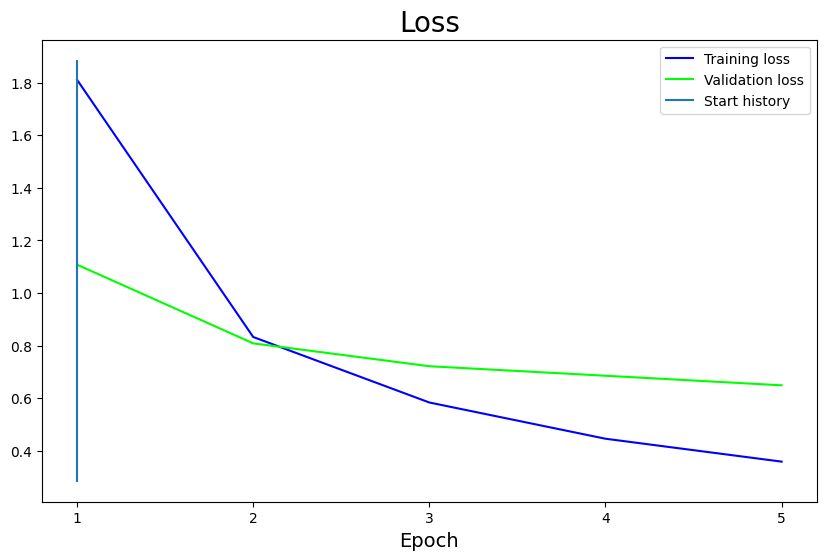

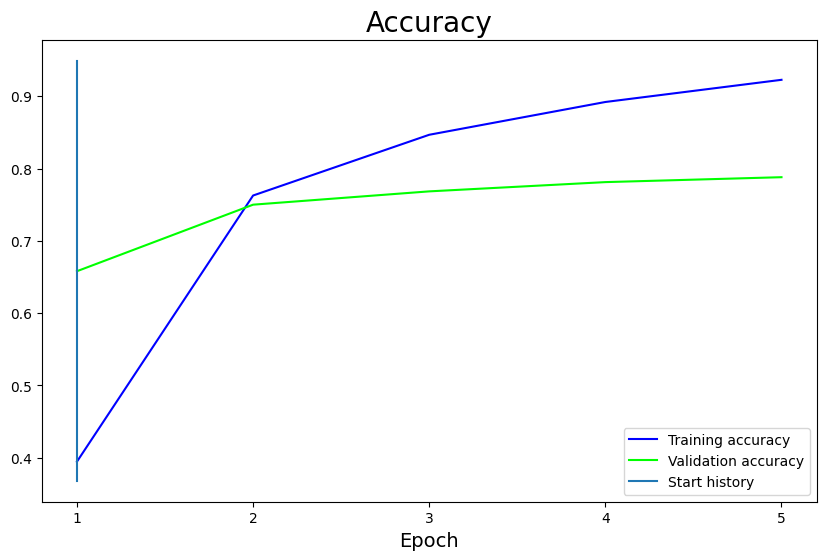

In [12]:
soml.tf.model.plot.plot_history(history=resnet_history)

In [13]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [14]:
efficientnet_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [15]:
cb_tensorboard = soml.tf.model.callback.tensorboard_callback(experiment_name='efficientnetB0_model_history')

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])

Saving TensorBoard log files to: ./logs/efficientnetB0_model_history/20230831-222536
Epoch 1/5
24/24 [==============================] - 24s 470ms/step - loss: 1.9159 - accuracy: 0.3920 - val_loss: 1.3293 - val_accuracy: 0.7160
Epoch 2/5
24/24 [==============================] - 8s 329ms/step - loss: 1.0931 - accuracy: 0.7667 - val_loss: 0.8847 - val_accuracy: 0.8116
Epoch 3/5
24/24 [==============================] - 8s 322ms/step - loss: 0.7713 - accuracy: 0.8227 - val_loss: 0.7079 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 7s 319ms/step - loss: 0.6188 - accuracy: 0.8600 - val_loss: 0.6129 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 7s 306ms/step - loss: 0.5221 - accuracy: 0.8827 - val_loss: 0.5582 - val_accuracy: 0.8672


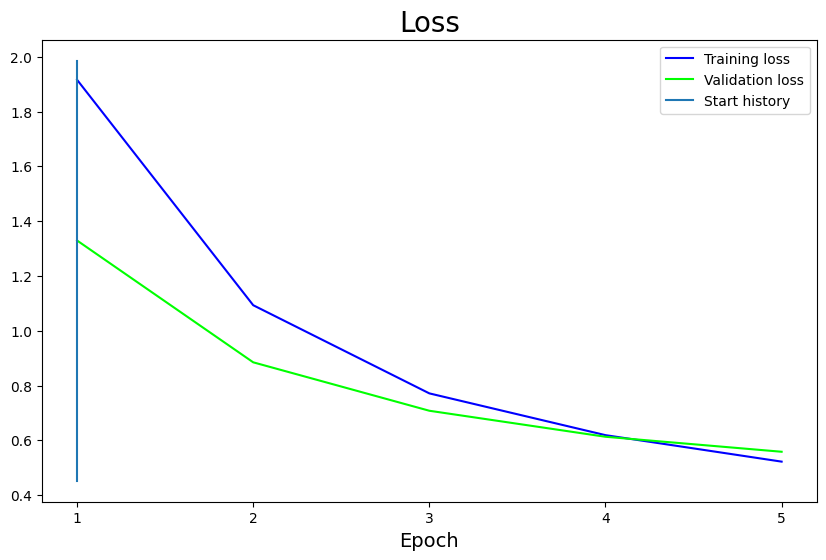

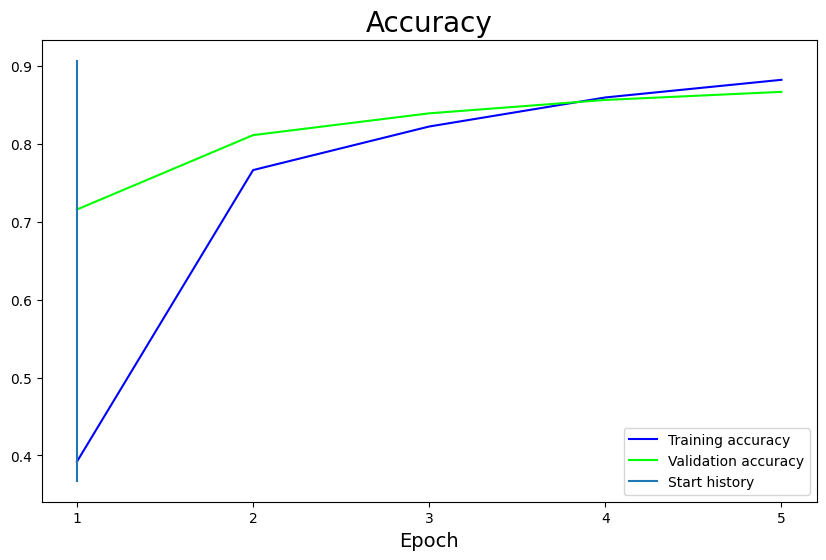

In [16]:
soml.tf.model.plot.plot_history(history=efficientnet_history)

In [17]:
len(efficientnet_model.layers[0].weights)

309

In [18]:
efficientnetB4_model = create_model(efficientnetB4_url, num_classes=train_data_10_percent.num_classes)
efficientnetB4_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1792)             17673816  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                17930     
                                                                 
Total params: 17,691,746
Trainable params: 17,930
Non-trainable params: 17,673,816
_________________________________________________________________


In [19]:
efficientnetB4_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [20]:
cb_tensorboard = soml.tf.model.callback.tensorboard_callback(experiment_name='efficientnetB4_model_history')

efficientnetB4_history = efficientnetB4_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])

Saving TensorBoard log files to: ./logs/efficientnetB4_model_history/20230831-222702
Epoch 1/5
24/24 [==============================] - 47s 998ms/step - loss: 1.6803 - accuracy: 0.5547 - val_loss: 1.0961 - val_accuracy: 0.7912
Epoch 2/5
24/24 [==============================] - 13s 577ms/step - loss: 0.9476 - accuracy: 0.7920 - val_loss: 0.7470 - val_accuracy: 0.8260
Epoch 3/5
24/24 [==============================] - 13s 553ms/step - loss: 0.7028 - accuracy: 0.8240 - val_loss: 0.6281 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 12s 527ms/step - loss: 0.5852 - accuracy: 0.8400 - val_loss: 0.5696 - val_accuracy: 0.8472
Epoch 5/5
24/24 [==============================] - 13s 536ms/step - loss: 0.5049 - accuracy: 0.8720 - val_loss: 0.5302 - val_accuracy: 0.8496


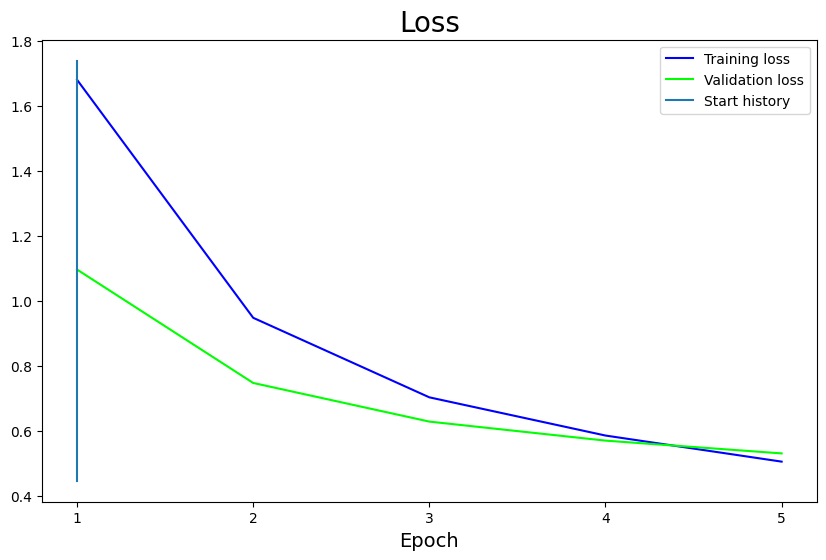

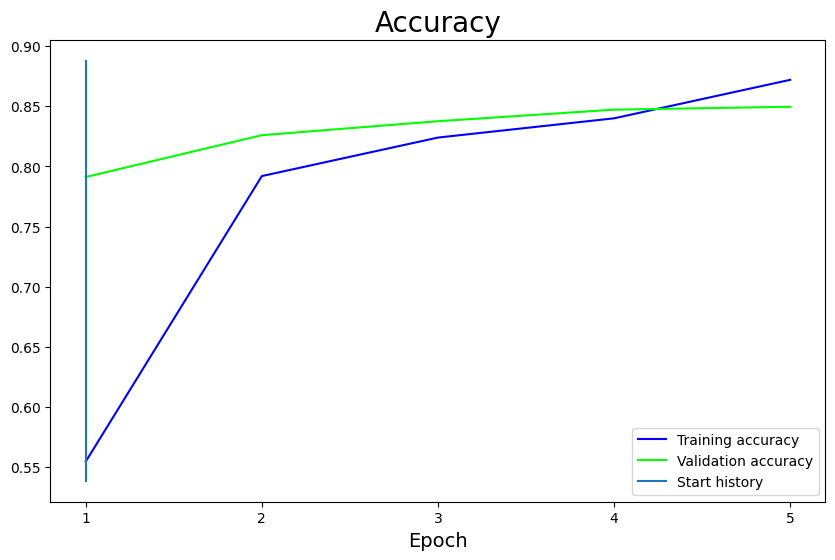

In [21]:
soml.tf.model.plot.plot_history(history=efficientnetB4_history)


In [22]:
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'

In [23]:
mobilenet_model = create_model(mobilenet_url, num_classes=train_data_10_percent.num_classes)
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
mobilenet_model.compile(loss=categorical_crossentropy,
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [25]:
cb_tensorboard = soml.tf.model.callback.tensorboard_callback(experiment_name='mobilenetv2_100_224_model_history')

mobilenetv2_100_224_model_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[cb_tensorboard])

Saving TensorBoard log files to: ./logs/mobilenetv2_100_224_model_history/20230831-222844
Epoch 1/5
24/24 [==============================] - 14s 427ms/step - loss: 1.8977 - accuracy: 0.3720 - val_loss: 1.2279 - val_accuracy: 0.6504
Epoch 2/5
24/24 [==============================] - 8s 324ms/step - loss: 1.0159 - accuracy: 0.7187 - val_loss: 0.8603 - val_accuracy: 0.7460
Epoch 3/5
24/24 [==============================] - 7s 315ms/step - loss: 0.7307 - accuracy: 0.8160 - val_loss: 0.7251 - val_accuracy: 0.7760
Epoch 4/5
24/24 [==============================] - 7s 315ms/step - loss: 0.5791 - accuracy: 0.8587 - val_loss: 0.6622 - val_accuracy: 0.7960
Epoch 5/5
24/24 [==============================] - 7s 312ms/step - loss: 0.4793 - accuracy: 0.8867 - val_loss: 0.6477 - val_accuracy: 0.7896


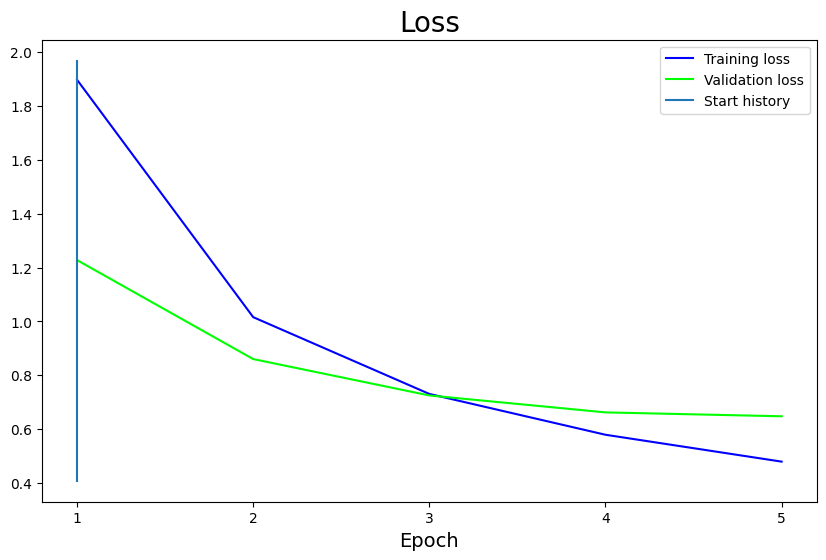

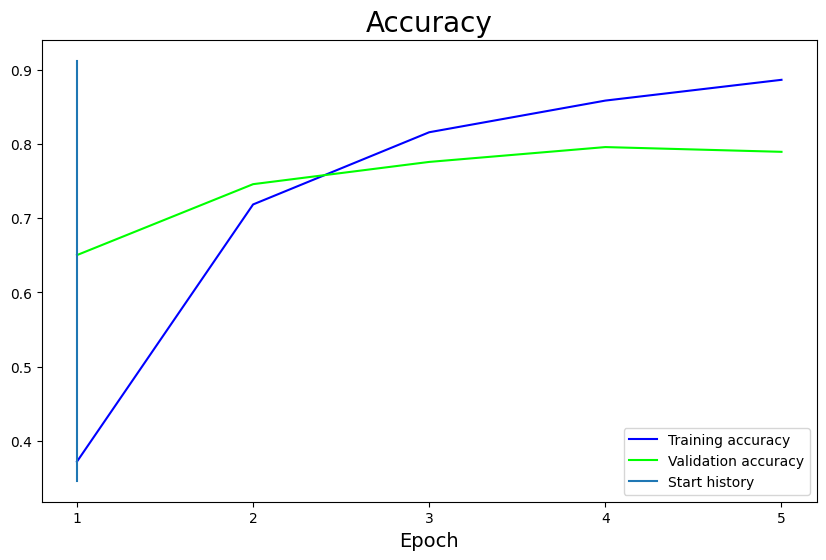

In [26]:
soml.tf.model.plot.plot_history(history=mobilenetv2_100_224_model_history)